In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import folium
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

In [2]:
customers_df = pd.read_excel('/kaggle/input/egypt-e-commerce-transactions-data/E-commerce_data.xlsx', sheet_name='customers')
genders_df = pd.read_excel('/kaggle/input/egypt-e-commerce-transactions-data/E-commerce_data.xlsx', sheet_name='genders')
cities_df = pd.read_excel('/kaggle/input/egypt-e-commerce-transactions-data/E-commerce_data.xlsx', sheet_name='cities')
transactions_df = pd.read_excel('/kaggle/input/egypt-e-commerce-transactions-data/E-commerce_data.xlsx', sheet_name='transactions')

In [3]:
df = customers_df.merge(genders_df, on='gender_id').merge(cities_df, on='city_id')

In [4]:
transaction_summary = transactions_df.groupby('customer_id').agg({
    'transaction_id': 'count',
    'transaction_status': lambda x: (x == 'subscribed').sum(),
}).rename(columns={'transaction_id': 'total_transactions', 'transaction_status': 'subscribed_count'}).reset_index()

In [5]:
df = df.merge(transaction_summary, on='customer_id', how='left').fillna(0)
df

,customer_id,join_date,city_id,gender_id,gender_name,city_name,total_transactions,subscribed_count
0,1,2022-01-08,7,1,Male,Mansoura,7.0,4.0
1,2,2023-05-02,20,2,Female,Sohag,3.0,2.0
2,3,2023-05-14,15,1,Male,Aswan,5.0,4.0
3,4,2022-11-25,11,2,Female,Ismailia,1.0,1.0
4,5,2023-04-26,8,1,Male,El-Mahalla El-Kubra,4.0,1.0
...,...,...,...,...,...,...,...,...
995,996,2022-10-28,3,1,Male,Giza,3.0,3.0
996,997,2022-07-07,20,2,Female,Sohag,3.0,2.0
997,998,2024-03-09,11,2,Female,Ismailia,4.0,1.0
998,999,2022-07-16,6,1,Male,Suez,4.0,0.0


In [6]:
features = df[['gender_name', 'city_name', 'total_transactions', 'subscribed_count']]

In [7]:
features = pd.get_dummies(features, drop_first=True)

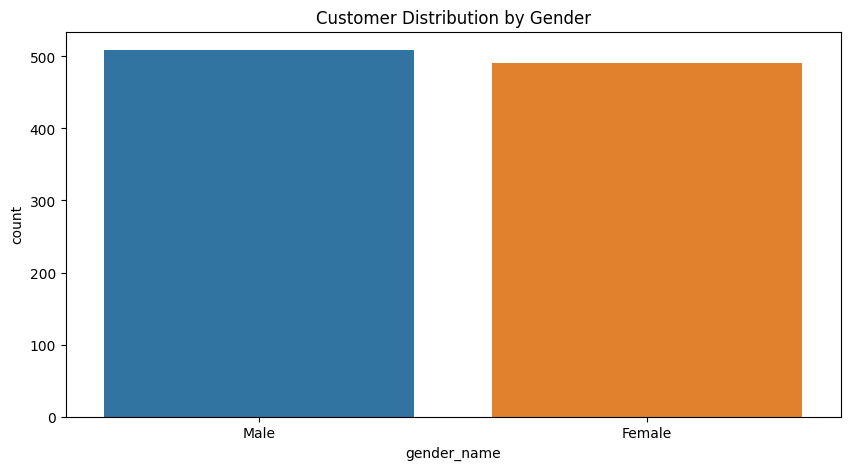

In [8]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='gender_name')
plt.title('Customer Distribution by Gender')
plt.show()

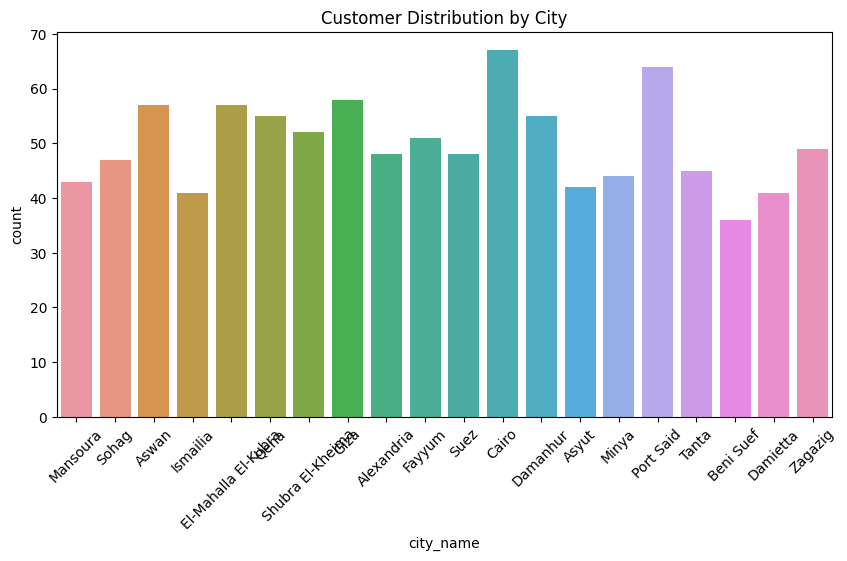

In [9]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='city_name')
plt.title('Customer Distribution by City')
plt.xticks(rotation=45)
plt.show()

In [10]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [11]:
inertia = []
silhouette_scores = []
K = range(2, 11)

In [12]:
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

Text(0, 0.5, 'Inertia')

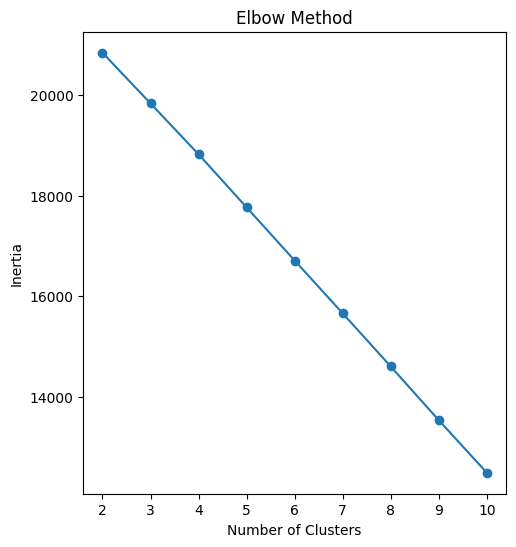

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

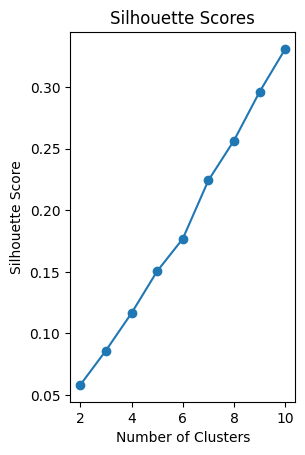

In [14]:
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [15]:
calinski_scores = []
davies_bouldin_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    labels = kmeans.labels_
    calinski_scores.append(calinski_harabasz_score(scaled_features, labels))
    davies_bouldin_scores.append(davies_bouldin_score(scaled_features, labels))

Text(0, 0.5, 'Calinski-Harabasz Score')

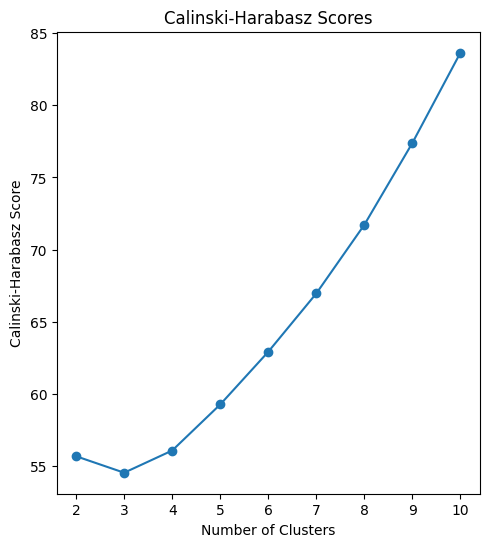

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(K, calinski_scores, marker='o')
plt.title('Calinski-Harabasz Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')

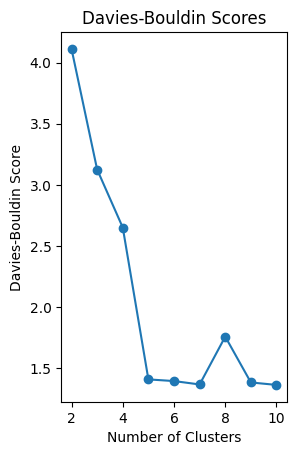

In [17]:
plt.subplot(1, 2, 2)
plt.plot(K, davies_bouldin_scores, marker='o')
plt.title('Davies-Bouldin Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.show()

In [18]:
optimal_k = 2

In [19]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_features)

In [20]:
segment_analysis = df.groupby('cluster').agg({
    'total_transactions': 'mean',
    'subscribed_count': 'mean',
    'gender_name': lambda x: x.mode()[0],
    'city_name': lambda x: x.mode()[0],
}).reset_index()

print(segment_analysis)

   cluster  total_transactions  subscribed_count gender_name  city_name
0        0            7.046798          3.916256        Male      Cairo
1        1            3.601010          1.505051      Female  Port Said


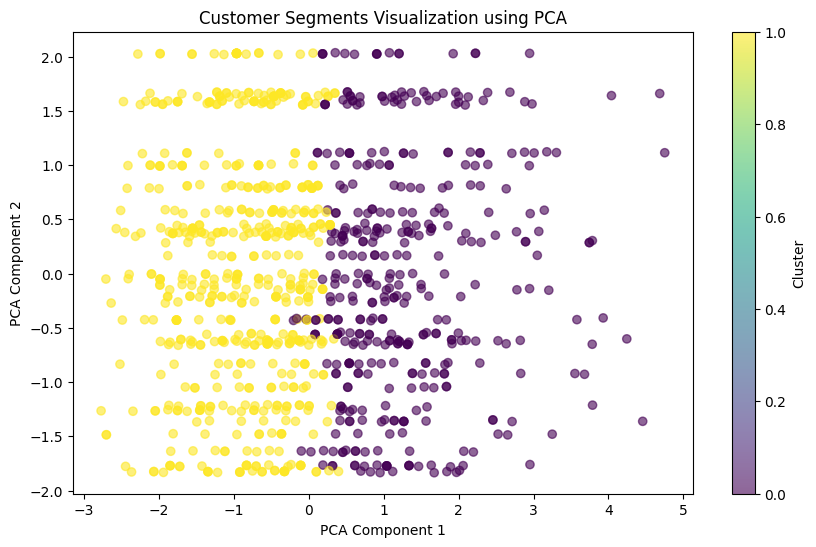

In [21]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=df['cluster'], cmap='viridis', alpha=0.6)
plt.title('Customer Segments Visualization using PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

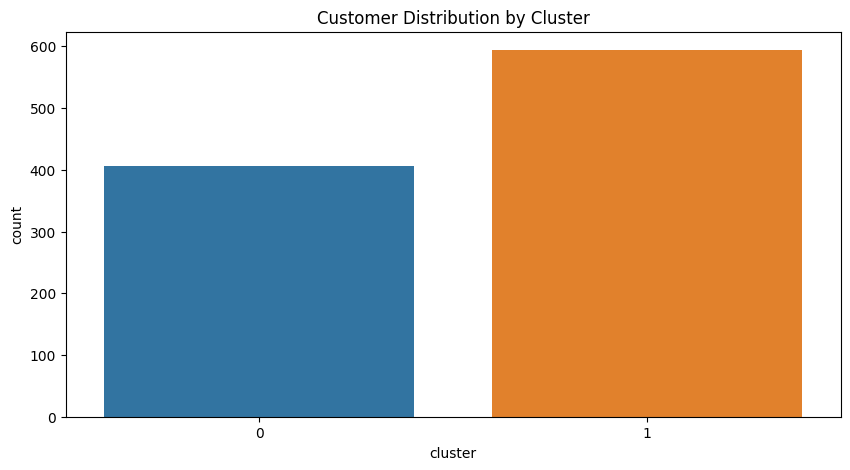

In [22]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='cluster')
plt.title('Customer Distribution by Cluster')
plt.show()

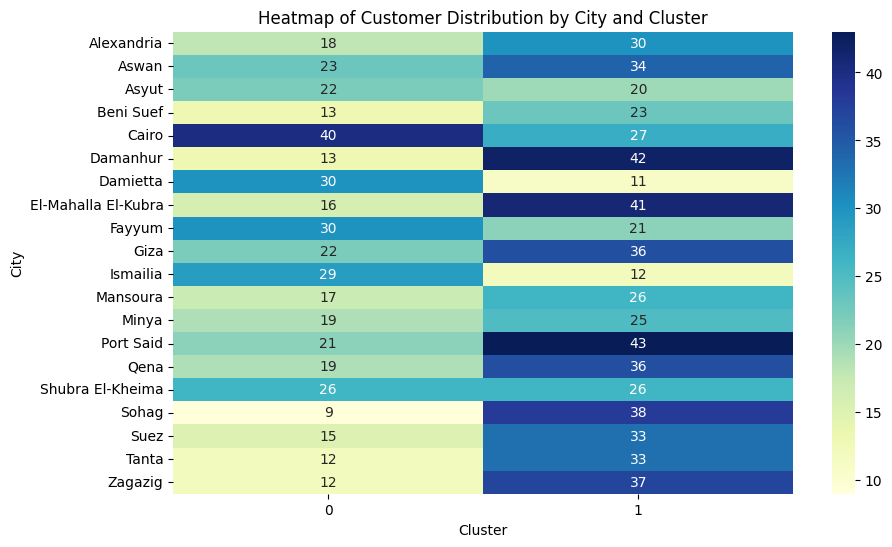

In [23]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.groupby(['city_name', 'cluster']).size().unstack(), cmap='YlGnBu', annot=True)
plt.title('Heatmap of Customer Distribution by City and Cluster')
plt.xlabel('Cluster')
plt.ylabel('City')
plt.show()

In [24]:
for index, row in segment_analysis.iterrows():
    print(f"Segment {row['cluster']}:")
    print(f" - Average Transactions: {row['total_transactions']:.2f}")
    print(f" - Average Subscribed: {row['subscribed_count']:.2f}")
    print(f" - Common Gender: {row['gender_name']}")
    print(f" - Common City: {row['city_name']}")
    print(" - Recommended to offer coupons to increase loyalty and satisfaction.")

Segment 0:
 - Average Transactions: 7.05
 - Average Subscribed: 3.92
 - Common Gender: Male
 - Common City: Cairo
 - Recommended to offer coupons to increase loyalty and satisfaction.
Segment 1:
 - Average Transactions: 3.60
 - Average Subscribed: 1.51
 - Common Gender: Female
 - Common City: Port Said
 - Recommended to offer coupons to increase loyalty and satisfaction.


In [25]:
segment_analysis.to_excel('customer_segments.xlsx', index=False)